# PROJET ANALYSE DES DONNÉES EN GRANDES DIMENSIONS


## 0. Analyse exploratoire

### Importation des données et des bibliothèques nécessaires

In [110]:
#Import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as scipy
from scipy import stats
import statsmodels.api as sm

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, Lasso,lars_path,Ridge,RidgeCV,LogisticRegression
from sklearn.metrics import mean_squared_error,r2_score,confusion_matrix,f1_score,make_scorer, roc_auc_score,accuracy_score, mean_absolute_error,roc_curve,auc

from sklearn.preprocessing import MinMaxScaler, LabelEncoder,StandardScaler
from feature_engine.outliers import Winsorizer
import feature_engine.transformation as vt
from sklearn.utils import resample

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

import plotly.graph_objects as go


In [111]:
#IMPORTATION ELODIE
df_blanc=pd.read_csv('/content/winequality-white.csv',sep=';')
df_rouge=pd.read_csv('/content/winequality-red.csv',sep=';')
df_blanc.info()
df_rouge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column        

### Vin Blanc et Vin Rouge séparé

#### Statistiques du jeu de données

In [112]:
def stat(df):
  # Nombre de lignes et de colonnes
  num_rows, num_cols = df.shape

  # Variables quantitatives
  quantitative_vars = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
  num_quantitative_vars = len(quantitative_vars)

  # Variables qualitatives
  qualitative_vars = df.select_dtypes('object').columns.tolist()
  num_qualitative_vars = len(qualitative_vars)

  # Valeurs manquantes
  total_missing_values = df.isna().sum().sum()  # Calculer le nombre total de valeurs manquantes : 0 ici

  #Valeurs nulles
  valeurs_nulles=(df==0).sum().sum()
  # Doublons
  num_duplicates = df.duplicated().sum() #1177 : plusieurs fois le même vin ou des vins avec exactement les mêmes caractéristiques

  # Récapitulatif
  summary = {"Informations": ["Nombre de lignes", "Nombre de colonnes", "Variables quantitatives", "Variables qualitatives", "Valeurs manquantes", "Valeurs nulles","Doublons"],
    "Valeurs": [num_rows, num_cols, num_quantitative_vars, num_qualitative_vars, total_missing_values,valeurs_nulles, num_duplicates],}
  summary_df = pd.DataFrame(summary)
  return(summary_df)

stat(df_blanc)

,Informations,Valeurs
0,Nombre de lignes,4898
1,Nombre de colonnes,12
2,Variables quantitatives,12
3,Variables qualitatives,0
4,Valeurs manquantes,0
5,Valeurs nulles,19
6,Doublons,937


In [113]:
stat(df_rouge)

,Informations,Valeurs
0,Nombre de lignes,1599
1,Nombre de colonnes,12
2,Variables quantitatives,12
3,Variables qualitatives,0
4,Valeurs manquantes,0
5,Valeurs nulles,132
6,Doublons,240


In [114]:
df_blanc=df_blanc.drop_duplicates().reset_index(drop=True)
df_rouge=df_rouge.drop_duplicates().reset_index(drop=True)

In [115]:
df_blanc.describe().round(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,3961.00,3961.00,3961.00,3961.00,3961.00,3961.00,3961.00,3961.00,3961.00,3961.00,3961.00,3961.00
mean,6.84,0.28,0.33,5.91,0.05,34.89,137.19,0.99,3.20,0.49,10.59,5.85
std,0.87,0.10,0.12,4.86,0.02,17.21,43.13,0.00,0.15,0.11,1.22,0.89
min,3.80,0.08,0.00,0.60,0.01,2.00,9.00,0.99,2.72,0.22,8.00,3.00
25%,6.30,0.21,0.27,1.60,0.04,23.00,106.00,0.99,3.09,0.41,9.50,5.00
50%,6.80,0.26,0.32,4.70,0.04,33.00,133.00,0.99,3.18,0.48,10.40,6.00
75%,7.30,0.33,0.39,8.90,0.05,45.00,166.00,1.00,3.29,0.55,11.40,6.00
max,14.20,1.10,1.66,65.80,0.35,289.00,440.00,1.04,3.82,1.08,14.20,9.00


In [116]:
df_rouge.describe().round(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00
mean,8.31,0.53,0.27,2.52,0.09,15.89,46.83,1.00,3.31,0.66,10.43,5.62
std,1.74,0.18,0.20,1.35,0.05,10.45,33.41,0.00,0.16,0.17,1.08,0.82
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.74,0.33,8.40,3.00
25%,7.10,0.39,0.09,1.90,0.07,7.00,22.00,1.00,3.21,0.55,9.50,5.00
50%,7.90,0.52,0.26,2.20,0.08,14.00,38.00,1.00,3.31,0.62,10.20,6.00
75%,9.20,0.64,0.43,2.60,0.09,21.00,63.00,1.00,3.40,0.73,11.10,6.00
max,15.90,1.58,1.00,15.50,0.61,72.00,289.00,1.00,4.01,2.00,14.90,8.00


#### Changement de la variable cible

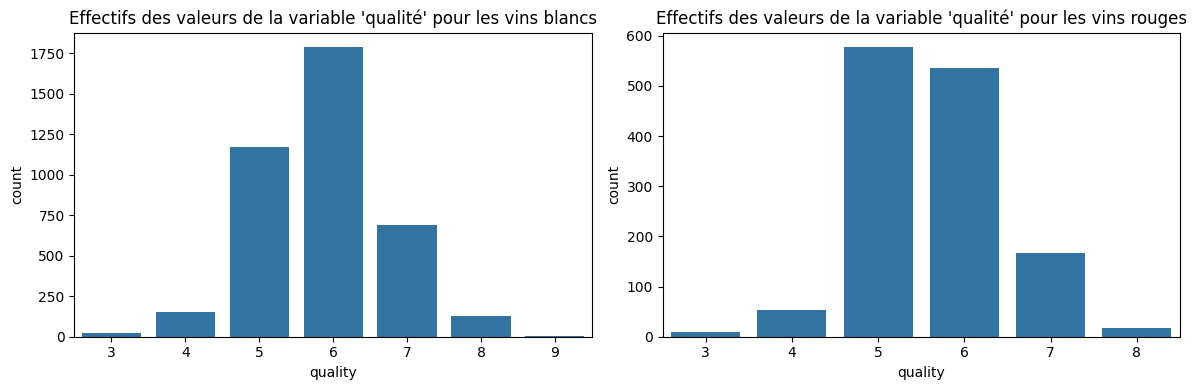

In [117]:
# Effectif de la variable 'quality'
fig, (ax1, ax2)=plt.subplots(1, 2,figsize=(12, 4))

sns.countplot(x="quality", data=df_blanc, ax=ax1)
sns.countplot(x="quality", data=df_rouge, ax=ax2)
ax1.set_title("Effectifs des valeurs de la variable 'qualité' pour les vins blancs")
ax2.set_title("Effectifs des valeurs de la variable 'qualité' pour les vins rouges")
plt.tight_layout()

In [118]:
#Changement des catégories de 'quality'
def chang_quality(df):
  df_copy=df.copy()
  df_copy['quality'] = df_copy['quality'].apply(lambda x:
                                    1 if x in [3, 4, 5] else
                                     (2 if x == 6 else
                                      (3 if x in [7, 8, 9] else None)))
  return(df_copy)
df1=chang_quality(df_blanc)
df2=chang_quality(df_rouge)

In [119]:
# Proportion dans chaque nouvelle catégorie
counts_df1 = df1.quality.value_counts(normalize=True).reset_index()
counts_df2 = df2.quality.value_counts(normalize=True).reset_index()

counts_df1.columns=['Quality', 'Count_Vin_Blanc']
counts_df2.columns=['Quality', 'Count_Vin_Rouge']
merged_counts = pd.merge(counts_df1, counts_df2, on='Quality', how='outer')
print(merged_counts.sort_values(by='Quality'))

   Quality  Count_Vin_Blanc  Count_Vin_Rouge
0        1         0.340318         0.470935
1        2         0.451401         0.393672
2        3         0.208281         0.135394


In [120]:
def concat (df1,df2):
  df_1 = df1.drop(['quality'],axis=1).copy()
  df_1['type'] = 1
  df_1['quality']=df1['quality']
  df_2 = df2.drop(['quality'],axis=1).copy()
  df_2['type'] = 0
  df_2['quality']=df2['quality']
  df=pd.concat([df_1, df_2], ignore_index=True)
  return(df)

In [121]:
from scipy.stats import kruskal
df=concat(df1,df2)
for v in df.columns.tolist():
  if v!='quality':
    groups = [df[df['quality'] == i][v] for i in range(1, 4)]
    kruskal_statistic, kruskal_p = kruskal(*groups)
    print(v + ": p-value Kruskal-Wallis = " + str(kruskal_p))

fixed acidity: p-value Kruskal-Wallis = 3.0292509154858305e-13
volatile acidity: p-value Kruskal-Wallis = 5.012014562527055e-81
citric acid: p-value Kruskal-Wallis = 2.6088693506487543e-15
residual sugar: p-value Kruskal-Wallis = 0.004346026036980001
chlorides: p-value Kruskal-Wallis = 2.3993271454955904e-113
free sulfur dioxide: p-value Kruskal-Wallis = 4.900699980377465e-08
total sulfur dioxide: p-value Kruskal-Wallis = 4.0766202035192086e-07
density: p-value Kruskal-Wallis = 7.530218089147531e-153
pH: p-value Kruskal-Wallis = 7.230313546747315e-05
sulphates: p-value Kruskal-Wallis = 0.043432503581295016
alcohol: p-value Kruskal-Wallis = 1.619293786635417e-283
type: p-value Kruskal-Wallis = 1.382447761902912e-18


#### Matrice de corrélation entre les caractéristiques

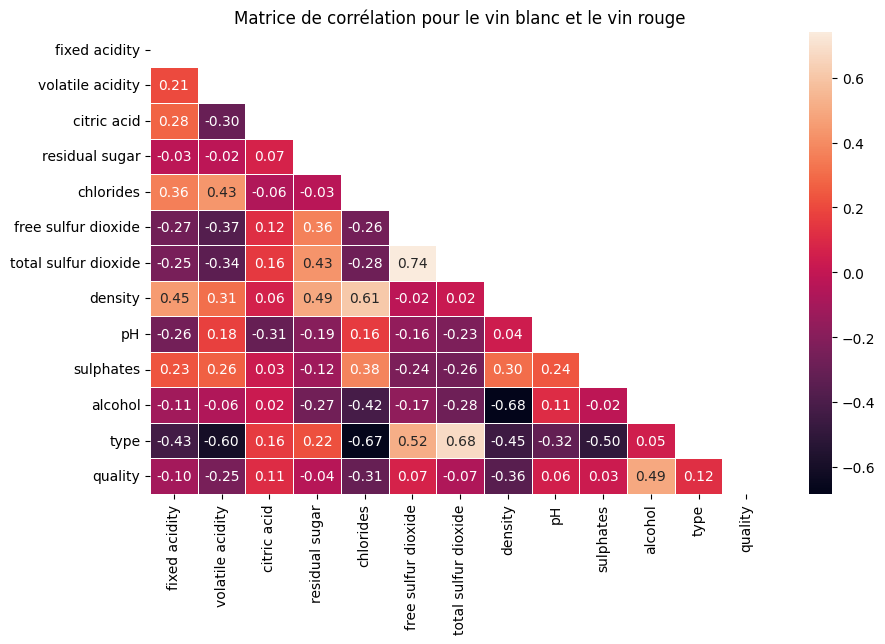

In [122]:
corr_matrix_df = df.corr(method='spearman')

# Masque
mask_df = np.triu(np.ones_like(corr_matrix_df, dtype=bool))

fig,ax=plt.subplots(figsize=(10, 6))

sns.heatmap(corr_matrix_df, annot=True, fmt=".2f", linewidths=.5, mask=mask_df,ax=ax)
ax.set_title("Matrice de corrélation pour le vin blanc et le vin rouge");

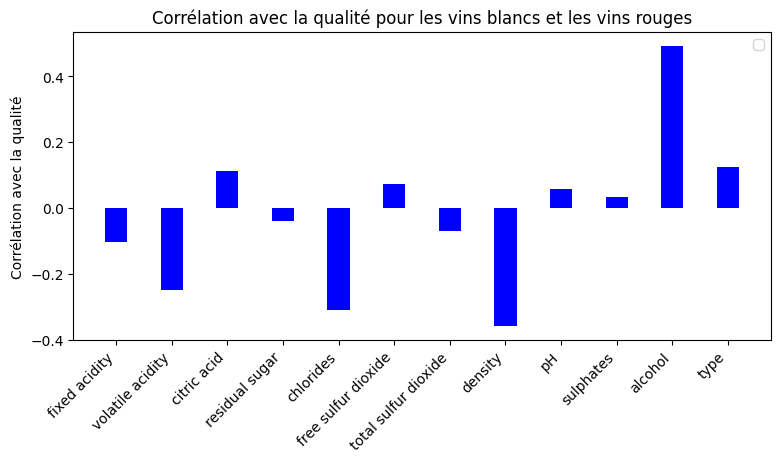

In [123]:
fig,ax=plt.subplots(figsize=(9, 4))

positions_df1 = range(len(corr_matrix_df['quality'][:-1]))
positions_df2 = [pos + 0.4 for pos in positions_df1]

ax.bar(positions_df1, corr_matrix_df['quality'][:-1], width=0.4, color='blue')

ax.set_xticks(positions_df1)
ax.set_xticklabels(corr_matrix_df['quality'][:-1].index, rotation=45, ha='right')
ax.set_ylabel("Corrélation avec la qualité")
ax.set_title('Corrélation avec la qualité pour les vins blancs et les vins rouges')
ax.legend()
plt.show()

#### Distributions des variables

In [124]:
def visualisation_var(df, variable,target):
    plt.figure(figsize=(20, 4))

    # barplot
    plt.subplot(1, 4, 1)
    sns.barplot(x = target, y = variable, data = df)
    plt.title(f'Diagramme à barres de {variable}')

    # boxplot
    plt.subplot(1, 4, 2)
    sns.boxplot(x=df[target],y=df[variable],color = 'b')
    plt.title(f'Boîtes à moustaches de {variable}')

    # histogram
    plt.subplot(1, 4, 3)
    sns.histplot(df[variable], bins=30,color = 'r')
    plt.title(f'Histogramme de {variable}')

    # scatterplot
    plt.subplot(1, 4, 4)
    sns.regplot(x=df[variable], y=df[target], color='g')
    plt.title(f'Diagramme de dispersion de {variable}')

    plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.



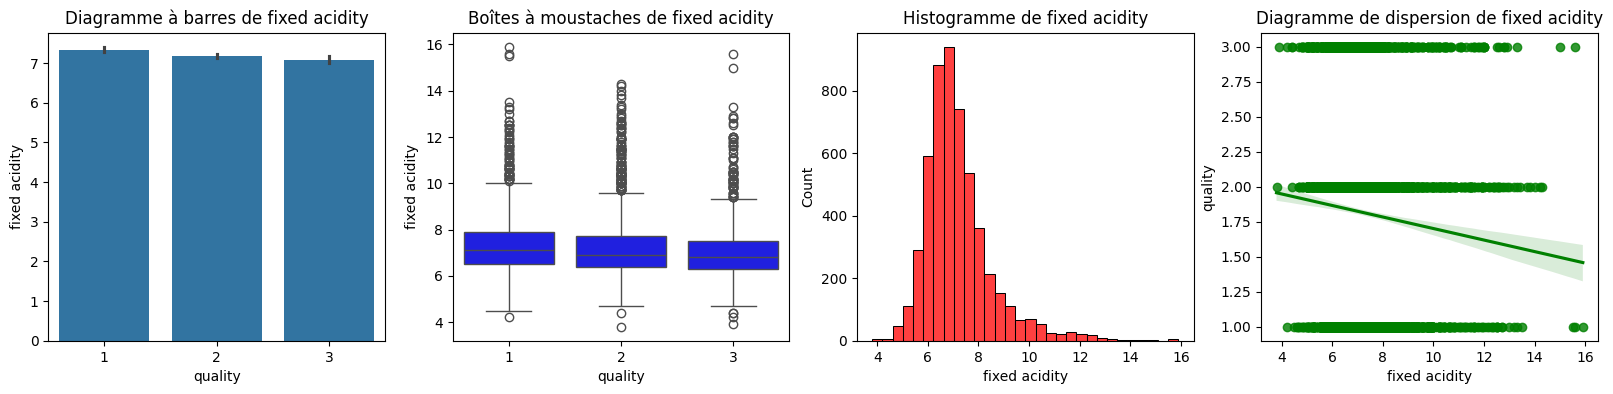

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.



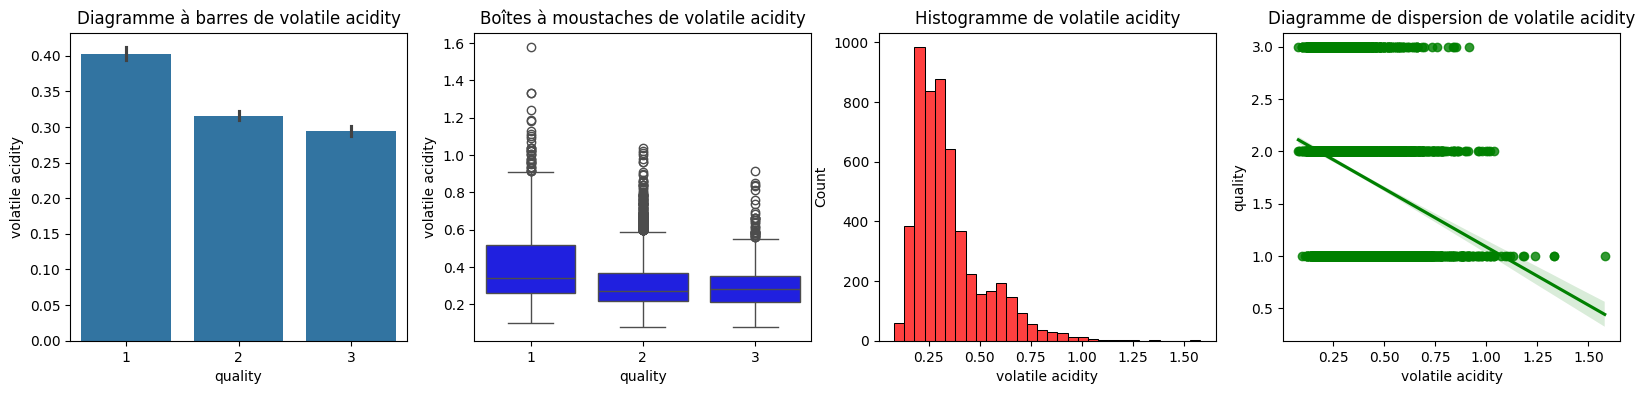

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.



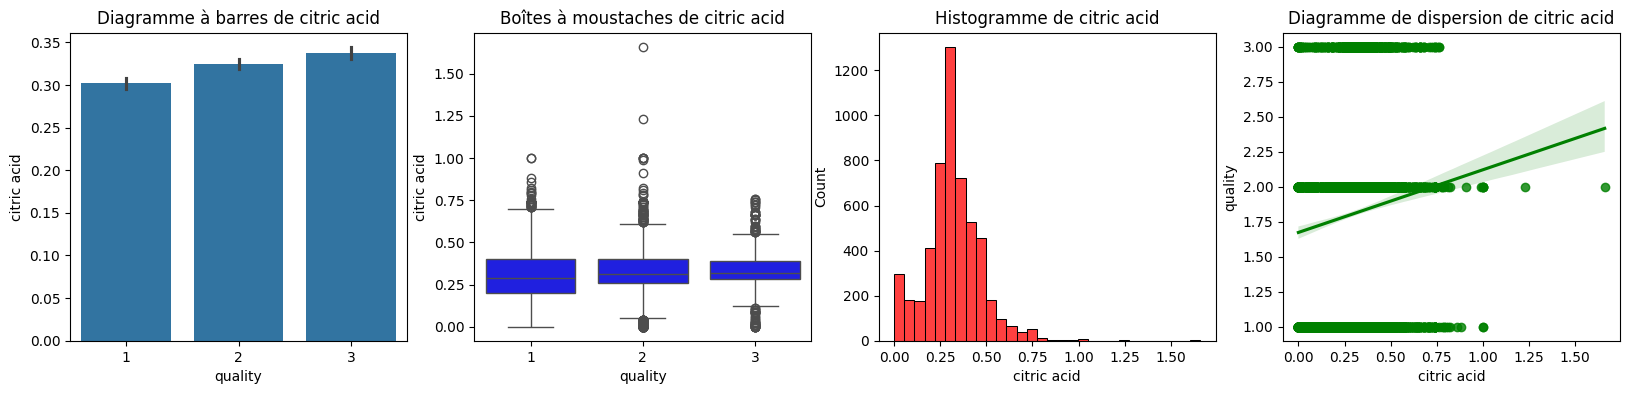

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.



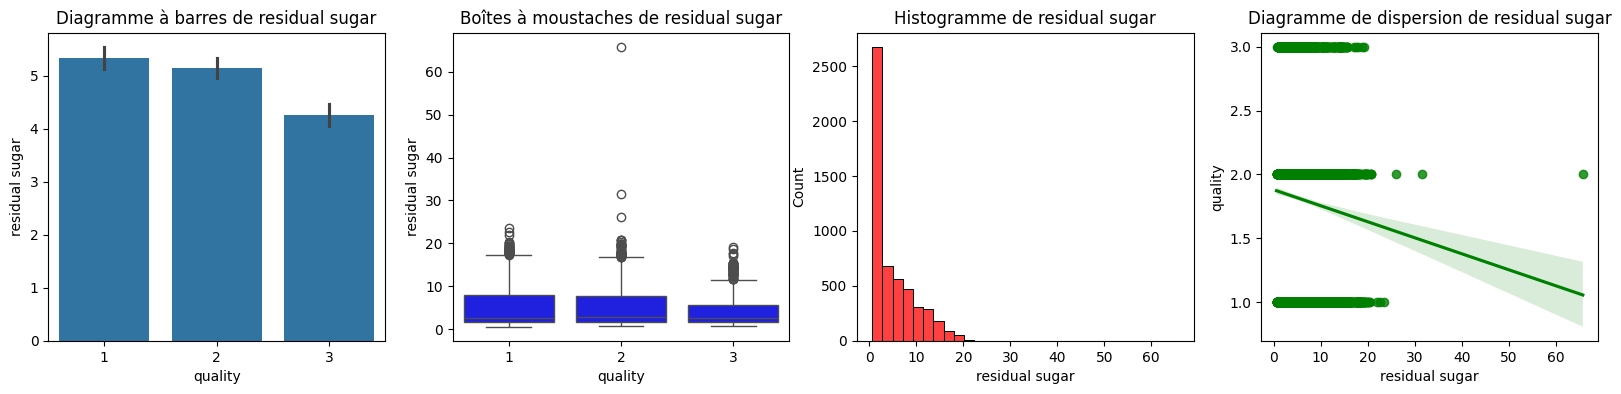

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.



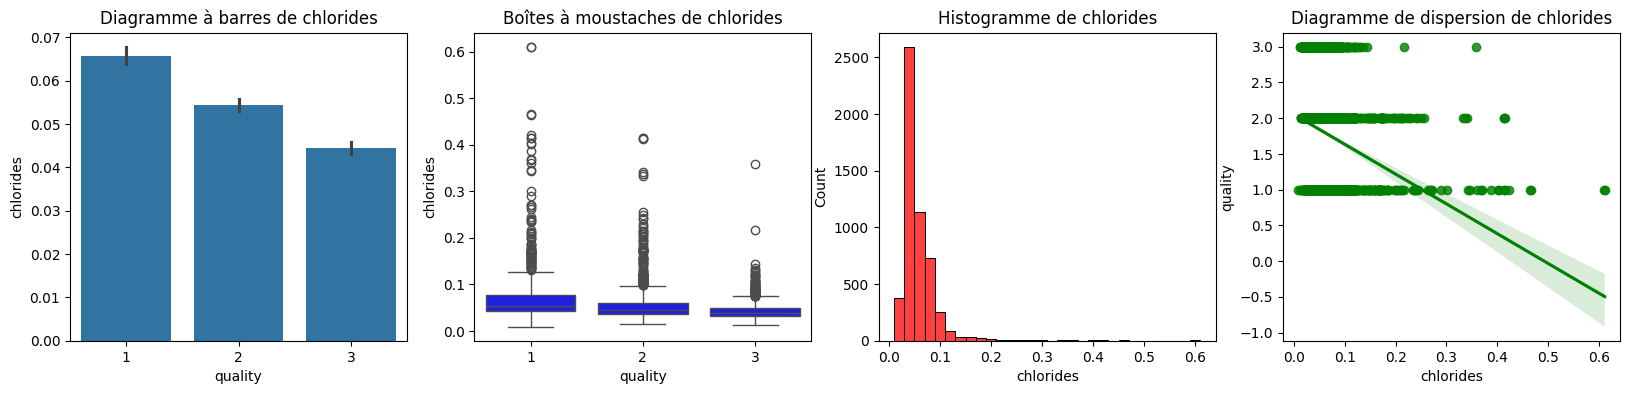

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.



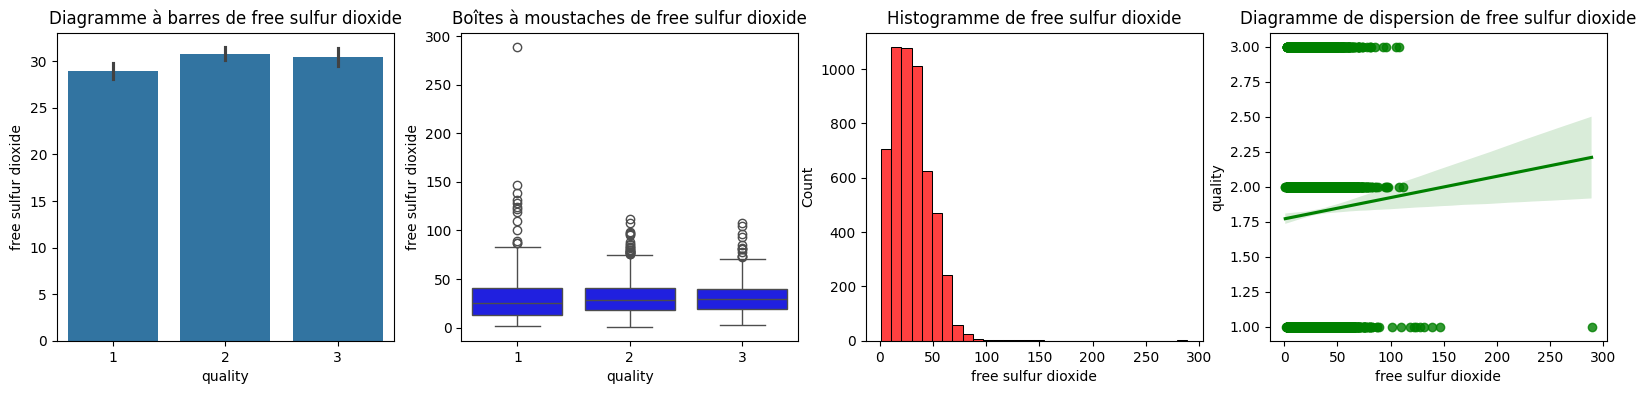

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.



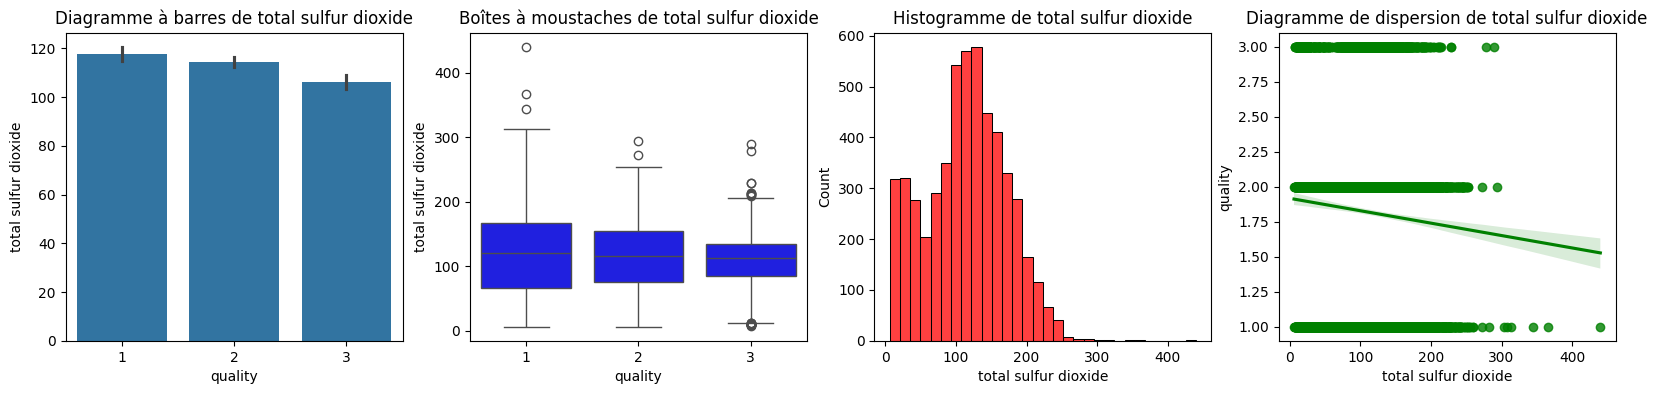

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.



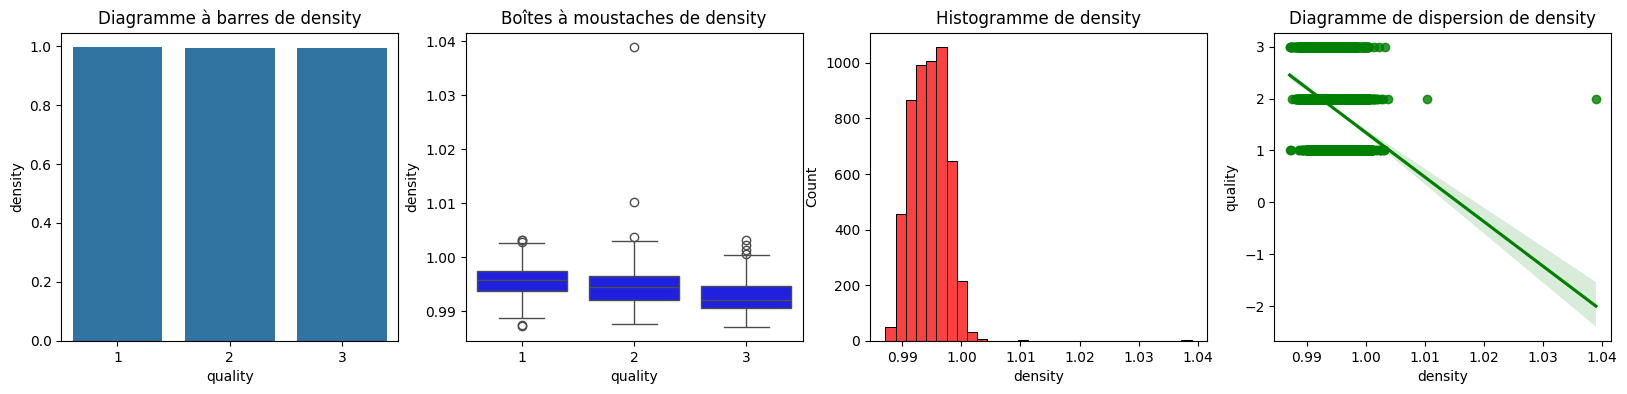

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.



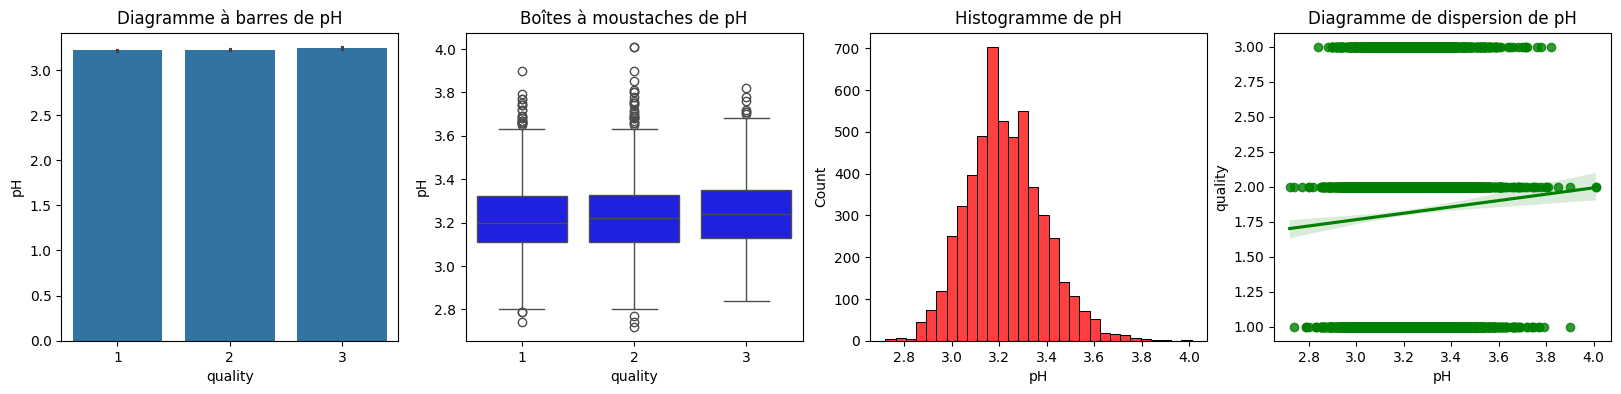

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.



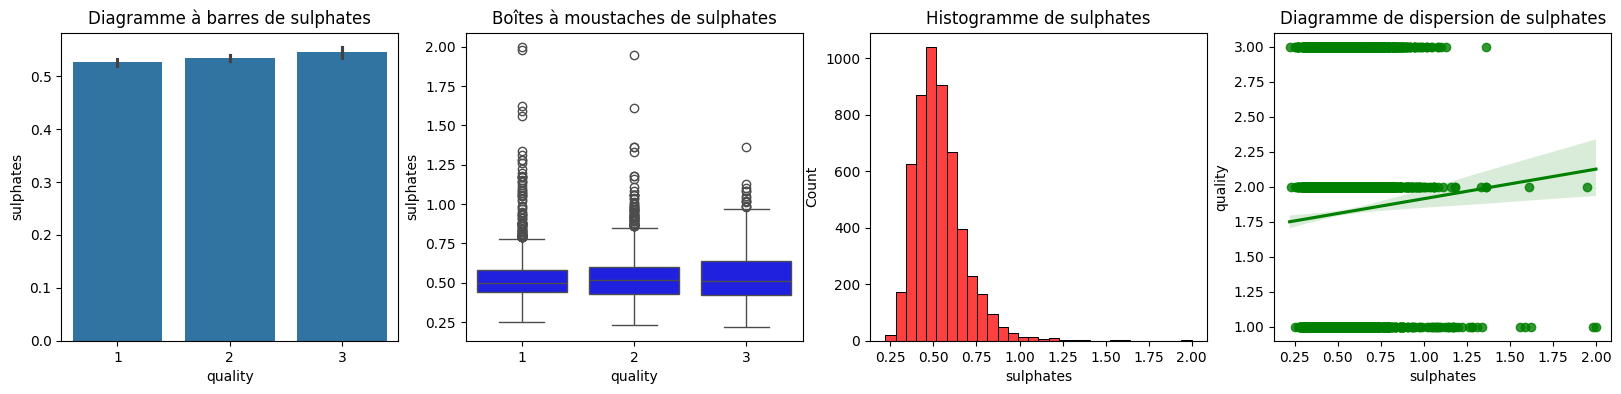

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning:

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.



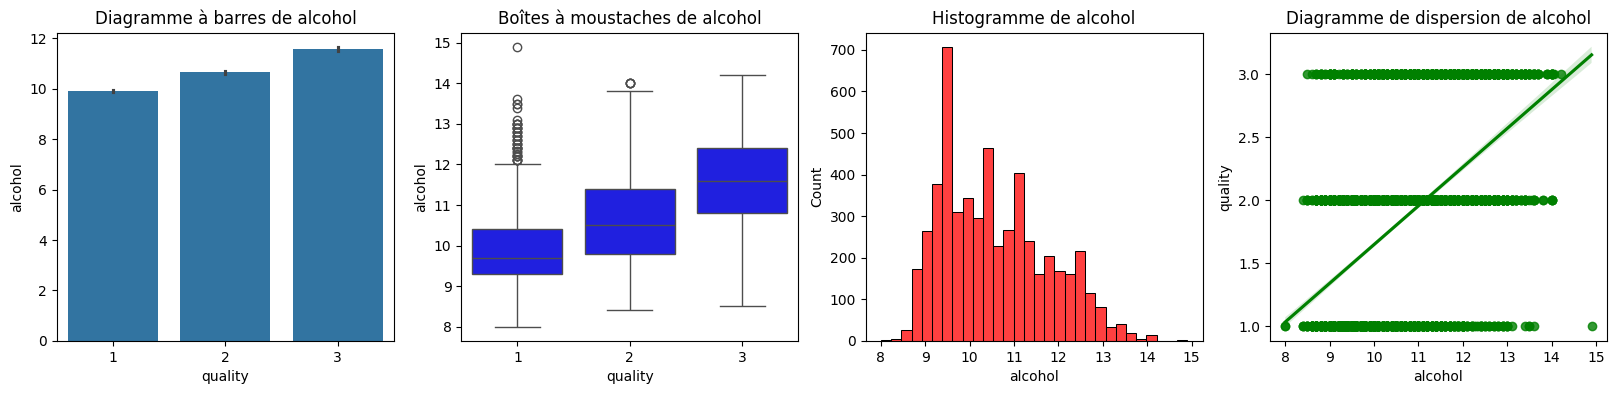

In [125]:
for variable in df.columns[:-2]:
    visualisation_var(df,variable,'quality')

In [126]:
def skew(df):
  skewness={}
  for col in df.columns:
    skewness[col]=scipy.stats.mstats.skew(df[col])
  return(pd.DataFrame(skewness, index=["skewness"]).transpose())

print(skew(df))

                      skewness
fixed acidity         1.649952
volatile acidity      1.504133
citric acid           0.484172
residual sugar        1.706069
chlorides             5.336732
free sulfur dioxide   1.362335
total sulfur dioxide  0.063596
density               0.666138
pH                    0.389859
sulphates             1.808944
alcohol               0.545542
type                 -1.121489
quality               0.297236


#### Nettoyage du set de données

In [127]:
threshold = 3

def detect_extrem(series, threshold=threshold):
  Q1 = series.quantile(0.25)
  Q3 = series.quantile(0.75)
  IQR = Q3 - Q1
  borne_inf = Q1 - threshold * IQR
  borne_sup = Q3 + threshold * IQR
  return (series < borne_inf) | (series > borne_sup)

def source_extrem(row):
    for col in df1.columns:
        if row[col]:
            return col
    return None

mask_extrem = df.apply(detect_extrem)
count_extrem = mask_extrem.any(axis=1).sum()
percentage_extrem = (count_extrem / len(df)) * 100
print(f"Il y a {count_extrem} lignes avec des valeurs aberrantes en utilisant l'écart interquartile avec un seuil de {threshold}.")
print(f"Cela représente {percentage_extrem:.2f}% d'observations de notre jeu de données.")
df_extrem=df.copy()
df_extrem['outlier'] = mask_extrem.any(axis=1)
df_extrem['source_outlier'] = mask_extrem.apply(source_extrem, axis=1)

Il y a 260 lignes avec des valeurs aberrantes en utilisant l'écart interquartile avec un seuil de 3.
Cela représente 4.89% d'observations de notre jeu de données.


In [128]:
display(df_extrem[df_extrem['outlier']==True].sort_values(by='chlorides',ascending=False))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality,outlier,source_outlier
4187,7.7,0.41,0.76,1.80,0.611,8.0,45.0,0.99680,3.06,1.26,9.4,0,1,True,chlorides
4096,9.2,0.52,1.00,3.40,0.610,32.0,69.0,0.99960,2.74,2.00,9.4,0,1,True,citric acid
4057,7.8,0.41,0.68,1.70,0.467,18.0,69.0,0.99730,3.08,1.31,9.3,0,1,True,chlorides
4036,7.8,0.43,0.70,1.90,0.464,22.0,67.0,0.99740,3.13,1.28,9.4,0,1,True,chlorides
4560,8.6,0.49,0.51,2.00,0.422,16.0,62.0,0.99790,3.03,1.17,9.0,0,1,True,chlorides
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3261,6.1,1.10,0.16,4.40,0.033,8.0,109.0,0.99058,3.35,0.47,12.4,1,1,True,volatile acidity
2860,7.7,0.43,1.00,19.95,0.032,42.0,164.0,0.99742,3.29,0.50,12.0,1,2,True,citric acid
2955,6.8,0.45,0.28,26.05,0.031,27.0,122.0,1.00295,3.06,0.42,10.6,1,2,True,residual sugar
1501,7.7,0.49,1.00,19.60,0.030,28.0,135.0,0.99730,3.24,0.40,12.0,1,2,True,citric acid


In [129]:
counts_df_extrem=df_extrem.source_outlier.value_counts(normalize=True).reset_index()
print(counts_df_extrem)

        source_outlier  proportion
0            chlorides    0.438462
1        fixed acidity    0.280769
2     volatile acidity    0.134615
3            sulphates    0.061538
4          citric acid    0.038462
5  free sulfur dioxide    0.030769
6       residual sugar    0.007692
7                   pH    0.007692


In [130]:
df.describe().round(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
count,5320.00,5320.00,5320.00,5320.00,5320.00,5320.00,5320.00,5320.00,5320.00,5320.00,5320.00,5320.00,5320.00
mean,7.22,0.34,0.32,5.05,0.06,30.04,114.11,0.99,3.22,0.53,10.55,0.74,1.82
std,1.32,0.17,0.15,4.50,0.04,17.81,56.77,0.00,0.16,0.15,1.19,0.44,0.73
min,3.80,0.08,0.00,0.60,0.01,1.00,6.00,0.99,2.72,0.22,8.00,0.00,1.00
25%,6.40,0.23,0.24,1.80,0.04,16.00,74.00,0.99,3.11,0.43,9.50,0.00,1.00
50%,7.00,0.30,0.31,2.70,0.05,28.00,116.00,0.99,3.21,0.51,10.40,1.00,2.00
75%,7.70,0.41,0.40,7.50,0.07,41.00,153.25,1.00,3.33,0.60,11.40,1.00,2.00
max,15.90,1.58,1.66,65.80,0.61,289.00,440.00,1.04,4.01,2.00,14.90,1.00,3.00


In [131]:
def gestion_extremes(df,var):
  windsoriser = Winsorizer(capping_method='iqr',
                          tail='both',
                          fold=3,
                          variables=var)
  windsoriser.fit(df)
  return(windsoriser.transform(df))

In [132]:
def log_transform(df, var):
    df_copy = df.copy()
    for variable in var:
        df_copy[variable] = np.where(df_copy[variable] > 0, np.log1p(df_copy[variable]), df_copy[variable])

    return df_copy

In [133]:
var=['fixed acidity', 'volatile acidity', 'residual sugar','chlorides', 'free sulfur dioxide',  'density','sulphates','alcohol','type']
dfb=gestion_extremes(df,var)
df_clean=log_transform(dfb, var)

In [134]:
print(df_clean)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          2.079442          0.239017         0.36        3.077312   0.044017   
1          1.987874          0.262364         0.34        0.955511   0.047837   
2          2.208274          0.246860         0.40        2.066863   0.048790   
3          2.104134          0.207014         0.32        2.251292   0.056380   
4          1.974081          0.277632         0.16        2.079442   0.044017   
...             ...               ...          ...             ...        ...   
5315       2.054124          0.482426         0.08        1.064711   0.065788   
5316       1.974081          0.470004         0.08        1.098612   0.086178   
5317       1.931521          0.438255         0.10        1.163151   0.060154   
5318       1.931521          0.497740         0.12        1.098612   0.072321   
5319       1.945910          0.270027         0.47        1.526056   0.064851   

      free sulfur dioxide  

In [135]:
skew(df_clean)

,skewness
fixed acidity,0.734332
volatile acidity,1.039136
citric acid,0.484172
residual sugar,0.505370
chlorides,1.566298
free sulfur dioxide,-0.690710
total sulfur dioxide,0.063596
density,0.068148
pH,0.389859
sulphates,0.769803


### Préparation des données




In [136]:
#Standardisation des données
def mean_norm(df_input):
    return df_input.apply(lambda X: (X - X.mean()) / X.std(), axis=0)

In [137]:
def preparation(df):
  # Supprimer la target de X et la mettre dans un autre df
  X=df.drop('quality', axis=1)
  y=df['quality']
  # Diviser les données en ensembles d'entraînement et de test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)
  X_train = mean_norm(X_train)
  X_test= mean_norm(X_test)
  return(X,y,X_train, X_test, y_train, y_test)

In [138]:
X,y,X_train,X_test,y_train,y_test=preparation(df_clean)

## 1. Régression

### A. Régression Linéaire

In [139]:
# Première étape : Modèle complet
liste_reg=[]
coeff_determ=[]
score_mse=[]
score_mae=[]
def regression_lineaire(X_test,y_test,X_train,y_train,liste,coeff_determ,score_mse,score_mae):
  # Appliquer une régression linéaire
  X_train_final= sm.add_constant(X_train)
  linear_model = sm.OLS(y_train, X_train_final).fit()
  liste.append('Régression Linéaire')
  # Évaluer la performance du modèle sur l'ensemble de test
  X_test_final= sm.add_constant(X_test)
  predictions = linear_model.predict(X_test_final)

  mse = mean_squared_error(y_test, predictions)
  score_mse.append(mse)

  mae = mean_absolute_error(y_test, predictions)
  score_mae.append(mae)

  coeff_determ.append(linear_model.rsquared)

  # Afficher les résultats
  print(linear_model.summary())
  print(f'Erreur Absolue (MAE) : {mae}')
  print(f'Erreur Résiduelle (MSE) : {mse}')

In [140]:
print(regression_lineaire(X_test,y_test,X_train,y_train,liste_reg,coeff_determ,score_mse,score_mae))

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     167.9
Date:                Sat, 29 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:18:00   Log-Likelihood:                -3292.6
No. Observations:                3724   AIC:                             6611.
Df Residuals:                    3711   BIC:                             6692.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.8158 

In [141]:
# Test de White
from statsmodels.stats.diagnostic import het_white

X_train_final= sm.add_constant(X_train)
model_white = sm.OLS(y_train, X_train_final).fit()
_, p_value, _, _ = het_white(model_white.resid,X_train_final)

print("P-value du test de White :", p_value)

P-value du test de White : 6.087557483196252e-20


### B. Régression LASSO

In [142]:
def regression_lasso_1(X,y):

#############   TRAJECTOIRE DU LASSO   ###############
  #X=mean_norm(X.drop(['type'],axis=1))
  X=mean_norm(X)
  X_array = X.values
  y_array = y.values

  # Trajectoire du LASSO
  alphas, _, coefs =lars_path(X_array, y_array, method='lasso')

  neg_log_alphas_lasso = -np.log10(alphas)

  plt.figure(figsize=(13, 5))

  plt.plot(neg_log_alphas_lasso, coefs.T)
  plt.xlabel('-Log(α)')
  plt.ylabel('Coefficients')
  plt.title('Trajectoire solution du LASSO')
  plt.legend(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'type'])
  plt.show()

def regression_lasso_2(X_train,y_train):
  ##########   CHOIX DU ALPHA   #############
  alphas = np.logspace(-4, 5, 100)
  lasso_model=LassoCV(alphas=alphas,cv=5) #cv=nb de découpages de la validation croisée
  lasso_model.fit(X_train,y_train)
  alpha_optimal=lasso_model.alpha_
  print(f"Paramètre de régularisation optimal est : {alpha_optimal}")

def regression_lasso_3(X_train,y_train,X_test,y_test,alpha,liste,coeff_determ,score_mse,score_mae):
  #############  MODELE DU LASSO ##############

  # Création du modèle Lasso avec le meilleur alpha, l'appliquer sur nos données d'entraînement et déterminer les prédicitions
  lasso_model = Lasso(alpha=alpha)
  lasso_model.fit(X_train, y_train)
  predictions = lasso_model.predict(X_test)
  liste.append('Régression LASSO')

  # Évaluer le modèle
  mse = mean_squared_error(y_test, predictions)
  score_mse.append(mse)
  mae = mean_absolute_error(y_test, predictions)
  score_mae.append(mae)

  r2 = lasso_model.score(X_train, y_train)
  coeff_determ.append(r2)
  # Coefficients du LASSO
  coefficients = lasso_model.coef_
  intercept = lasso_model.intercept_
  variable_coefficients = dict(zip(X.columns, coefficients))

  # Résultats
  print(f'Erreur absolue moyenne (MSE) : {mae}')
  print(f'Erreur quadratique moyenne (MSE) : {mse}')
  print(f'Coefficient de détermination (R^2) : {r2}')
  print('\nCoefficients attribués par le modèle Lasso :')
  print(f"Intercept: {intercept}")
  for variable, coefficient in variable_coefficients.items():
      print(f'{variable}: {coefficient}')
  # Bar plot des coefficients estimés
  plt.bar(range(len(coefficients)), coefficients)
  plt.xlabel("Coefficients")
  plt.ylabel("Valeur")
  plt.title(f"Coefficients estimés pour LassoCV avec la meilleure valeur de α: {alpha}")
  plt.show()

<ipython-input-142-1417244f21de>:12: RuntimeWarning:

divide by zero encountered in log10



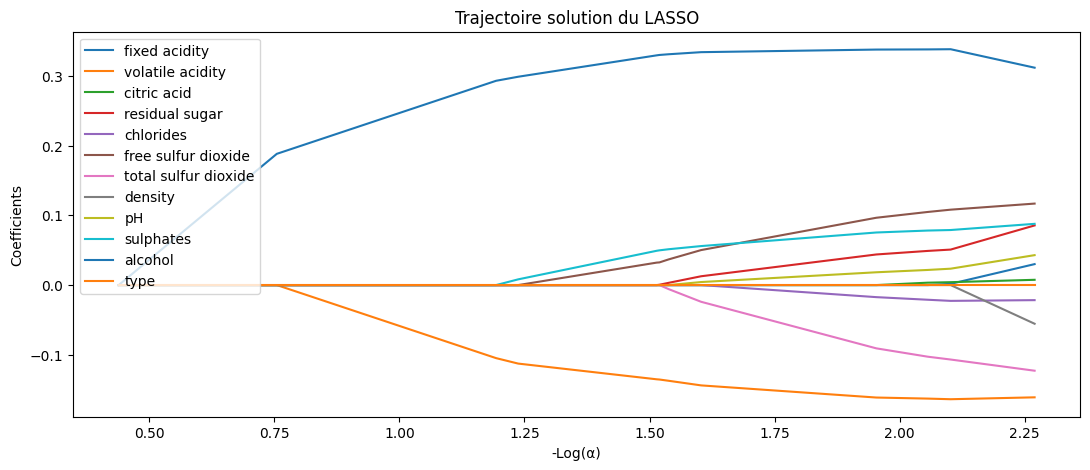

In [143]:
regression_lasso_1(X,y)

In [144]:
regression_lasso_2(X_train,y_train)

Paramètre de régularisation optimal est : 0.0001


Erreur absolue moyenne (MSE) : 0.4925921553373132
Erreur quadratique moyenne (MSE) : 0.35492505484557185
Coefficient de détermination (R^2) : 0.3518389689076843

Coefficients attribués par le modèle Lasso :
Intercept: 1.8157894736841989
fixed acidity: 0.09531782267460906
volatile acidity: -0.1772356843115473
citric acid: 0.01357742131098614
residual sugar: 0.17237004879840004
chlorides: -0.025446701066427567
free sulfur dioxide: 0.13906296505235644
total sulfur dioxide: -0.1414436287365038
density: -0.20562193357888864
pH: 0.07508232047428094
sulphates: 0.09383734624577668
alcohol: 0.2431080042870207
type: -0.06195421469915245


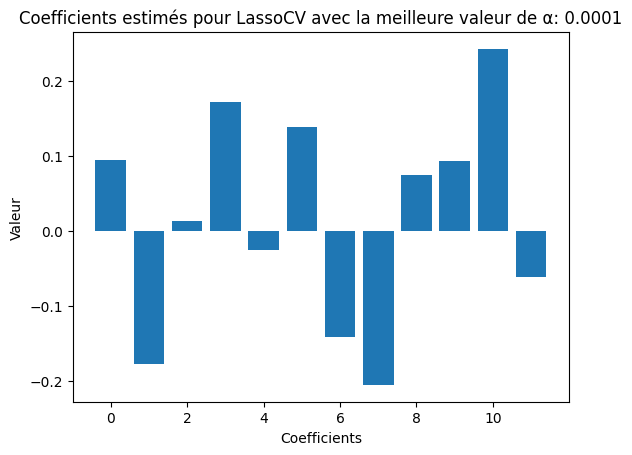

In [145]:
regression_lasso_3(X_train,y_train,X_test,y_test,0.0001,liste_reg,coeff_determ,score_mse,score_mae)

### C. Régression RIDGE


In [146]:
def regression_ridge_1(X1_train, y1_train, alphas=np.logspace(-4, 5, 100)):

    ##############   TRAJECTOIRE RIDGE   ###################
    coefs= []
    for alpha in alphas:
        ridge_model = RidgeCV(alphas=[alpha], cv=5)
        ridge_model.fit(X_train, y_train)
        coefs.append(ridge_model.coef_)

    neg_log_alphas_ridge = -np.log10(alphas)

    plt.figure(figsize=(13, 5))

    for i in range(coefs[0].shape[0]):
        plt.plot(neg_log_alphas_ridge, [coef[i] for coef in coefs], label=f'Variable {i+1}')

    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.xlabel('-Log(α)')
    plt.ylabel('Coefficients')
    plt.title('Trajectoire Solution du RIDGE')
    plt.legend()
    plt.show()

def regression_ridge_2(X1_train, y1_train, alphas=np.logspace(-4, 5, 100)):
    ############## CHOIX du meilleur ALPHA  ##################
    ridge_model= RidgeCV(alphas=alphas, cv=5)
    ridge_model.fit(X_train, y_train)
    alpha_optimal= ridge_model.alpha_
    print(f"Paramètre de régularisation optimal est : {alpha_optimal}")

def regression_ridge_3(X_train, y_train, X_test, y_test, alpha,liste,coeff_determ,score_mse,score_mae):
    ################ MODELE RIDGE #####################
    ridge_model=Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    liste.append("Régression RIDGE")
    y_pred= ridge_model.predict(X_test)

    # Calcul du R^2
    r2=ridge_model.score(X_train, y_train)
    coeff_determ.append(r2)
    mae = mean_absolute_error(y_test, y_pred)
    mse= mean_squared_error(y_test, y_pred)
    score_mse.append(mse)
    score_mae.append(mae)

    print(f'Erreur absolue moyenne (MSE) : {mae}')
    print(f'Erreur quadratique moyenne (MSE) : {mse}')
    print(f'Coefficient de détermination (R^2) : {r2}')
    print('\nCoefficients attribués par le modèle Lasso :')

    # Coefficients estimés avec l'alpha optimal
    coefficients = ridge_model.coef_
    intercept = ridge_model.intercept_
    variable_coefficients = dict(zip(X.columns, coefficients))

    print(f"Intercept: {intercept}")
    for variable, coefficient in variable_coefficients.items():
      print(f'{variable}: {coefficient}')

    # Bar plot des coefficients estimés
    plt.bar(range(len(coefficients)), coefficients)
    plt.xlabel("Coefficients")
    plt.ylabel("Valeur")
    plt.title(f"Coefficients estimés pour RidgeCV avec la meilleure valeur de α: {alpha}")
    plt.show()

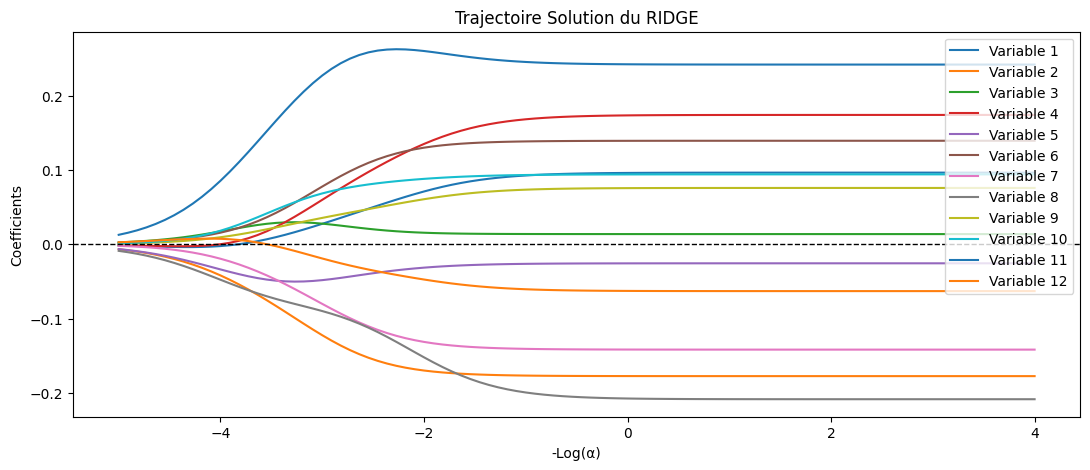

In [147]:
regression_ridge_1(X_train,y_train)

In [148]:
regression_ridge_2(X_train,y_train)

Paramètre de régularisation optimal est : 15.199110829529332


Erreur absolue moyenne (MSE) : 0.4927336754466488
Erreur quadratique moyenne (MSE) : 0.3548803716079747
Coefficient de détermination (R^2) : 0.35180613344194167

Coefficients attribués par le modèle Lasso :
Intercept: 1.8157894736841995
fixed acidity: 0.09077746372319154
volatile acidity: -0.1762116478019553
citric acid: 0.013931124148145279
residual sugar: 0.16542449368047854
chlorides: -0.026642213483084192
free sulfur dioxide: 0.13795926437470013
total sulfur dioxide: -0.1401137325316225
density: -0.1951066134851676
pH: 0.07241016202351996
sulphates: 0.09283066950735816
alcohol: 0.2468870031042981
type: -0.05930564786251465


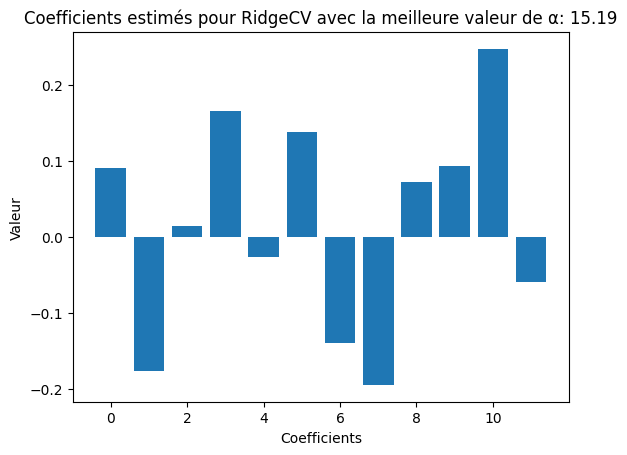

In [149]:
regression_ridge_3(X_train,y_train,X_test,y_test,15.19,liste_reg,coeff_determ,score_mse,score_mae)

### D. Random Forest Regressor

In [150]:
def rfr_param(X_train,y_train,X_test,y_test):
  forest_param_grid = {'n_estimators': [50, 100, 200],'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4],'max_features': ['auto', 'sqrt', 'log2'],'bootstrap': [True, False]}

  forest_regressor = RandomForestRegressor()

  forest_grid_search = RandomizedSearchCV(forest_regressor, forest_param_grid, cv=5, scoring='neg_mean_squared_error',random_state=42)
  forest_grid_search.fit(X_train, y_train)

  print("Meilleurs hyperparamètres pour la forêt de régression :", forest_grid_search.best_params_)

  forest_predictions = forest_grid_search.predict(X_test)

  #forest_mse = mean_squared_error(y_test, forest_predictions)
  #print("Erreur quadratique moyenne de la forêt de régression :", forest_mse)

  return(forest_grid_search)

In [151]:
def rfr(X_train,y_train,X_test,y_test,liste,coeff_determ,score_mse,score_mae):
  forest_model=rfr_param(X_train,y_train,X_test,y_test)
  best_forest_params = forest_model.best_params_
  best_forest_regressor = RandomForestRegressor(**best_forest_params)
  best_forest_regressor.fit(X_train, y_train)
  forest_prediction = best_forest_regressor.predict(X_test)
  liste.append("Forêt Aléatoire")

  r2=r2_score(y_test, forest_prediction)
  print("R2",r2)
  coeff_determ.append(r2)
  mse=mean_squared_error(y_test, forest_prediction)
  print("MSE",mse)
  score_mse.append(mse)
  mae=mean_absolute_error(y_test, forest_prediction)
  print("MAE",mae)
  score_mae.append(mae)

  return(forest_prediction)

In [152]:
pred=rfr(X_train,y_train,X_test,y_test,liste_reg,coeff_determ,score_mse,score_mae)
print(pred)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Meilleurs hyperparamètres pour la forêt de régression : {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': True}
R2 0.3953612783136903
MSE 0.32020465748187665
MAE 0.47175694440584254
[1.96372727 2.06574269 2.45353571 ... 1.78902493 2.34017063 2.11286436]


In [153]:
data_frame = {'Vraies valeurs': y_test,
    'Valeurs prédites': pred}

pred_vs_actu = pd.DataFrame(data_frame, columns=data_frame.keys())
pred_vs_actu.head()

,Vraies valeurs,Valeurs prédites
4878,1,1.963727
1434,2,2.065743
2989,2,2.453536
5235,2,1.872603
49,2,1.936103


### Ensemble des résultats

In [154]:
df_reg = pd.DataFrame({'Modèle de régression': liste_reg, 'R2': coeff_determ,'MAE': score_mae ,'MSE': score_mse}).sort_values(by="R2",ascending=False)
display(df_reg)

,Modèle de régression,R2,MAE,MSE
3,Forêt Aléatoire,0.395361,0.471757,0.320205
0,Régression Linéaire,0.351840,0.492560,0.354930
1,Régression LASSO,0.351839,0.492592,0.354925
2,Régression RIDGE,0.351806,0.492734,0.354880


## ACP

   Dimension  Variance expliquée  % variance expliquée  % cum. var. expliquée
0       Dim1            3.782530                  32.0                   32.0
1       Dim2            2.488885                  21.0                   52.0
2       Dim3            1.592479                  13.0                   66.0
3       Dim4            0.953528                   8.0                   73.0
4       Dim5            0.747896                   6.0                   80.0
5       Dim6            0.630265                   5.0                   85.0
6       Dim7            0.532616                   4.0                   89.0
7       Dim8            0.516030                   4.0                   94.0
8       Dim9            0.354521                   3.0                   97.0
9      Dim10            0.255394                   2.0                   99.0
10     Dim11            0.119601                   1.0                  100.0
11     Dim12            0.026255                   0.0          

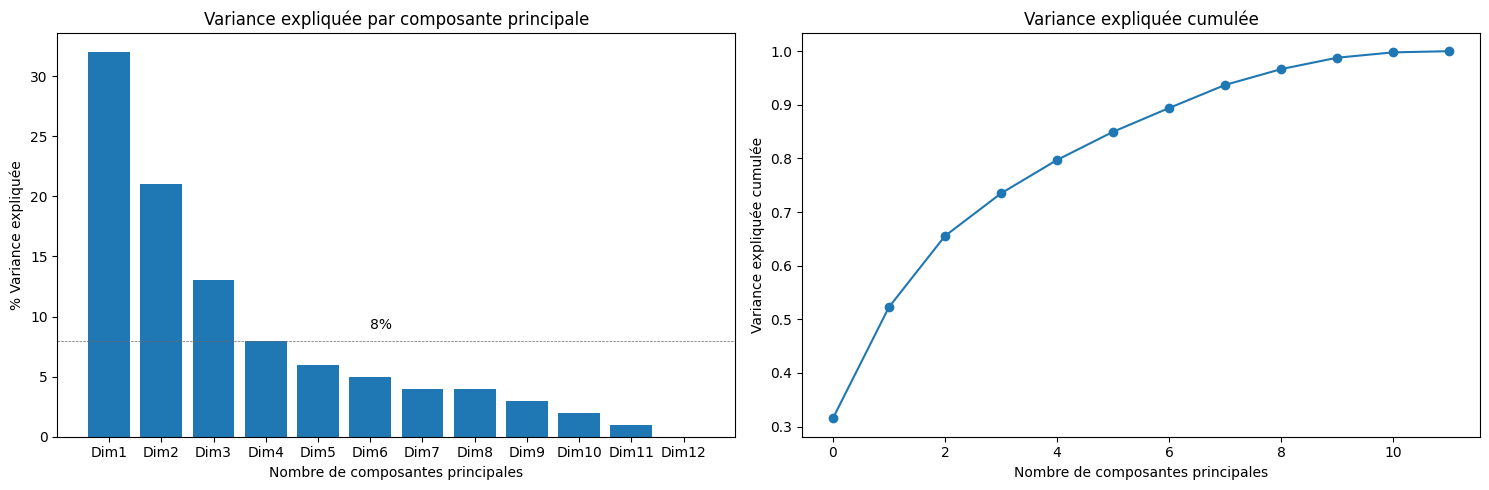

In [155]:
def ACP(df):
  X=df.drop(["quality"],axis=1)
  X=mean_norm(X)
  pca = PCA()
  pca.fit(X)
  X_pca = pca.fit_transform(X)
  columns = ['Dim1', 'Dim2', 'Dim3', 'Dim4', 'Dim5', 'Dim6', 'Dim7', 'Dim8', 'Dim9', 'Dim10', 'Dim11', 'Dim12']
  df_pca = pd.DataFrame(data=X_pca, columns=columns)
  X_pca = pd.DataFrame({"Dim1" : X_pca[:,0], "Dim2" : X_pca[:,1]})
  eig = pd.DataFrame(
    {"Dimension" : ["Dim" + str(x + 1) for x in range(12)],
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)})
  print(eig)

  explained_variance_ratio_cumsum = pca.explained_variance_ratio_.cumsum()
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  axes[0].bar(x=eig['Dimension'], height=eig['% variance expliquée'])
  axes[0].text(5, 9, "8%")
  axes[0].axhline(y=8, linewidth=.5, color="dimgray", linestyle="--")
  axes[0].set_xlabel('Nombre de composantes principales')
  axes[0].set_ylabel('% Variance expliquée')
  axes[0].set_title('Variance expliquée par composante principale')

  axes[1].plot(explained_variance_ratio_cumsum, marker='o')
  axes[1].set_xlabel('Nombre de composantes principales')
  axes[1].set_ylabel('Variance expliquée cumulée')
  axes[1].set_title('Variance expliquée cumulée')
  plt.tight_layout()
  plt.show()
  return(df_pca)

test=ACP(df)

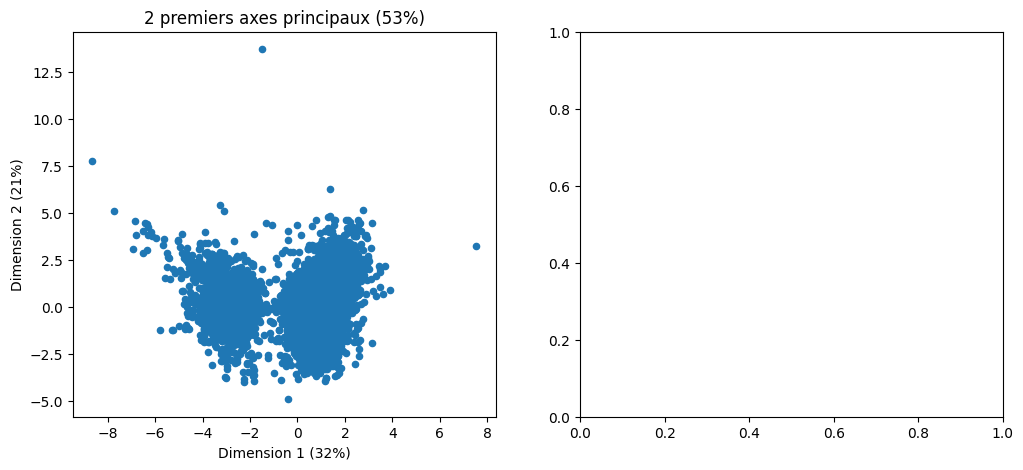

In [156]:
X_pca = test.iloc[:, :2]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Graphique Matplotlib - Nuage de points
X_pca.plot.scatter("Dim1", "Dim2", ax=axes[0])
axes[0].set_xlabel("Dimension 1 (32%)")
axes[0].set_ylabel("Dimension 2 (21%)")
axes[0].set_title("2 premiers axes principaux (53%)")

# Graphique Plotly - Nuage de points en 3D
fig_3d = go.Figure(data=[go.Scatter3d(x=test['Dim1'], y=test['Dim2'], z=test['Dim3'], mode='markers', marker=dict(size=3, color='red'))])
fig_3d.update_layout(scene=dict(xaxis_title='Dimension 1', yaxis_title='Dimension 2', zaxis_title='Dimension 3'), title='3 premiers axes principaux (66%)')

# Afficher les graphiques
plt.show()
fig_3d.show()

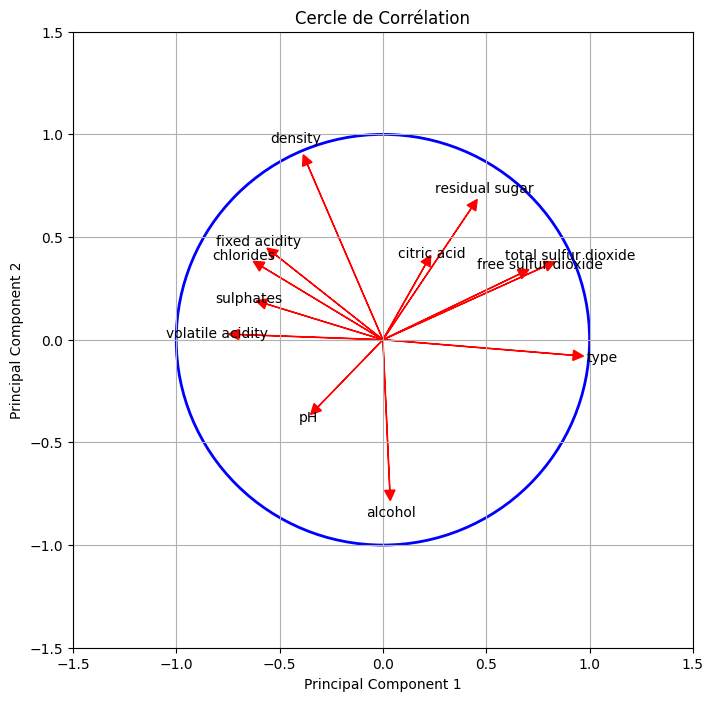

In [157]:
def ACP_cercle(df):
  X=df.drop(["quality"],axis=1)
  X=mean_norm(X)
  pca = PCA(4)
  X_pca = pca.fit_transform(X)


# Calcul des vecteurs propres (loadings) des composantes principales
  loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Tracé du cercle de corrélation
  plt.figure(figsize=(8, 8))
  plt.title('Cercle de Corrélation')

# Cercle
  circle = plt.Circle((0, 0), 1, edgecolor='b', facecolor='None', linewidth=2)
  plt.gca().add_patch(circle)

# Flèches pour les composantes principales
  for i, (comp_1, comp_2) in enumerate(zip(loadings[:, 0], loadings[:, 1])):
    plt.arrow(0, 0, comp_1, comp_2, head_width=0.05, head_length=0.05, fc='r', ec='r')
    plt.text(comp_1 * 1.15, comp_2 * 1.15, df.columns[i], color='black', ha='center', va='center')

  plt.xlim(-1.5, 1.5)
  plt.ylim(-1.5, 1.5)
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.grid(True)
  plt.show()



ACP_cercle(df)

In [158]:
########### Application ACP #########
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Appliquer la transformation inverse pour revenir à l'espace d'origine
X_train_original = pca.inverse_transform(X_train_pca)
X_test_original = pca.inverse_transform(X_test_pca)

In [159]:
liste_reg2=[]
coeff_determ2=[]
score_mse2=[]
score_mae2=[]
regression_lineaire(X_test_original,y_test,X_train_original,y_train,liste_reg2,coeff_determ2,score_mse2,score_mae2)
print(regression_lasso_2(X_train_original,y_train))
print(regression_ridge_2(X_train_original,y_train))

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     290.8
Date:                Sat, 29 Jun 2024   Prob (F-statistic):          7.47e-218
Time:                        16:19:02   Log-Likelihood:                -3593.3
No. Observations:                3724   AIC:                             7197.
Df Residuals:                    3719   BIC:                             7228.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8158      0.010    174.367      0.0

Erreur absolue moyenne (MSE) : 0.5337206050825871
Erreur quadratique moyenne (MSE) : 0.40881048363064204
Coefficient de détermination (R^2) : 0.23825294277754527

Coefficients attribués par le modèle Lasso :
Intercept: 1.8157894736842028
fixed acidity: -0.0
volatile acidity: -0.2196074309671026
citric acid: 0.0
residual sugar: -0.05973237324257527
chlorides: -0.0
free sulfur dioxide: 0.0
total sulfur dioxide: -0.0
density: -0.14260599112604405
pH: 0.0063062709330653985
sulphates: 0.13751456771218104
alcohol: 0.12509795963465278
type: 0.0


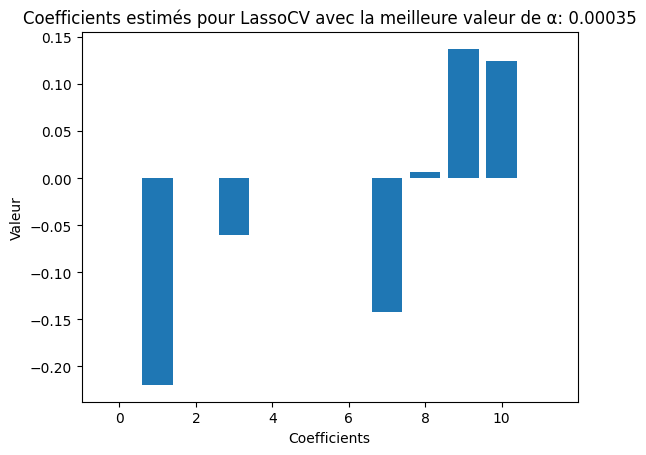

Erreur absolue moyenne (MSE) : 0.5337231219753158
Erreur quadratique moyenne (MSE) : 0.40879526701910374
Coefficient de détermination (R^2) : 0.23825230533033004

Coefficients attribués par le modèle Lasso :
Intercept: 1.8157894736842044
fixed acidity: -0.016301392810119577
volatile acidity: -0.09692178574124426
citric acid: 0.1018411269573021
residual sugar: -0.08586025870155513
chlorides: -0.05227900649705621
free sulfur dioxide: 0.017257529747488818
total sulfur dioxide: -0.006825220673411283
density: -0.11067776590929548
pH: 0.04436251386671468
sulphates: 0.09682438258924793
alcohol: 0.13180110068146364
type: 0.027919559338938263


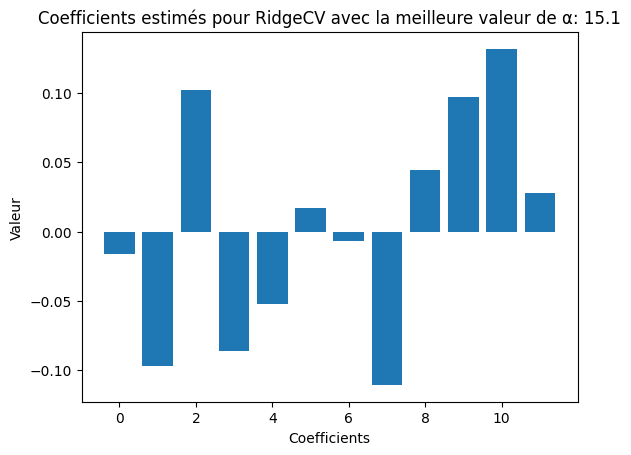

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

Meilleurs hyperparamètres pour la forêt de régression : {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
R2 0.29002145800849277
MSE 0.37599053402308774
MAE 0.5134413015226864


array([1.86665695, 1.92799915, 2.44066213, ..., 2.43010286, 1.85079186,
       1.79538779])

In [160]:
regression_lasso_3(X_train_original,y_train,X_test_original,y_test,0.00035,liste_reg2,coeff_determ2,score_mse2,score_mae2)
regression_ridge_3(X_train_original,y_train,X_test_original,y_test,15.1,liste_reg2,coeff_determ2,score_mse2,score_mae2)
rfr(X_train_original,y_train,X_test_original,y_test,liste_reg2,coeff_determ2,score_mse2,score_mae2)

In [161]:
print(liste_reg2)

['Régression Linéaire', 'Régression LASSO', 'Régression RIDGE', 'Forêt Aléatoire']


Voici les résultats de performance des quatre modèles de régression que nous avons choisis, évalués sur les nouvelles données définies par l'ACP :

In [162]:
df_reg2 = pd.DataFrame({'Modèle de régression': liste_reg2, 'R2': coeff_determ2,'MAE': score_mae2 ,'MSE': score_mse2}).sort_values(by="R2",ascending=False)
display(df_reg2)

,Modèle de régression,R2,MAE,MSE
3,Forêt Aléatoire,0.290021,0.513441,0.375991
0,Régression Linéaire,0.238254,0.533674,0.408798
1,Régression LASSO,0.238253,0.533721,0.408810
2,Régression RIDGE,0.238252,0.533723,0.408795


On constate que, même pour ces données, la forêt aléatoire semble être le modèle le plus approprié, avec le coefficient de détermination le plus élevé et l'erreur quadratique moyenne la plus basse. Cependant, l'ensemble des résultats est moins satisfaisant que ceux des données initiales, ce qui suggère que la réduction de dimension par l'ACP n'est pas adaptée et n'a pas amélioré la prédiction de la qualité du vin.

## 2. Classification

### Préparation des données


In [163]:
#Changement des catégories de 'quality'
def chang_quality2(df):
  df_copy=df.copy()
  df_copy['quality'] = df_copy['quality'].apply(lambda x:
                                    0 if x in [3, 4, 5,6] else 1)
  return(df_copy)

df=concat(df_blanc,df_rouge)
dfc=chang_quality2(df)

In [164]:
# Proportion dans chaque nouvelle catégorie
counts_dfc=df1.quality.value_counts(normalize=True).reset_index()
counts_dfc.columns=['Qualité', 'Effectif']
print(counts_dfc.sort_values(by='Qualité'))

   Qualité  Effectif
1        1  0.340318
0        2  0.451401
2        3  0.208281


In [165]:
Xc,yc,Xc_train,Xc_test,yc_train,yc_test=preparation(dfc) #Décomposition du jeu de VIN BLANC

In [166]:
from sklearn.metrics import recall_score,precision_score
from sklearn.metrics import classification_report

liste_algo=[]
score_f1=[]
score_acc=[]
score_recall=[]
score_prec=[]

def classification(algo, model,X_train,X_test,y_train,y_test):

  ########## MODELE et SCORE #############
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1=f1_score(y_test, y_pred)
    #score_vc=cross_val_score(model, X_train, y_train, cv=5,scoring='f1').mean() #La validation croisée vise à évaluer la performance du modèle sur différentes partitions de l'ensemble d'entraînement. Chaque partition sert successivement comme ensemble de validation, tandis que les autres partitions sont utilisées pour l'entraînement. Cela permet une évaluation plus robuste des performances du modèle.

    liste_algo.append(algo)
    score_f1.append(f1)
    score_acc.append(acc)
    score_prec.append(precision)
    score_recall.append(recall)

  ############# GRAPHIQUE : Matrice de confusion et Courbe ROC ##############
    fig,ax=plt.subplots(figsize=(8, 6))

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,
            cmap='Reds', annot_kws={'size': 15},
            square=True, fmt='.0f', ax=ax)

    ax.set_title(f'Matrice de confusion -- {algo}', fontsize=17)
    plt.show()

############## TABLEAU RECAPITULATIF METRIQUE ############

    print(f'======Pour {algo}======')
    #print(f'Accuracy : {acc} \n Précision : {precision} \n Recall : {recall} \n F1 Score: {f1} \n Score VC (Train): {score_vc}')
    print(classification_report(y_test, y_pred))
    print('\n')

### A. Régression Logistique

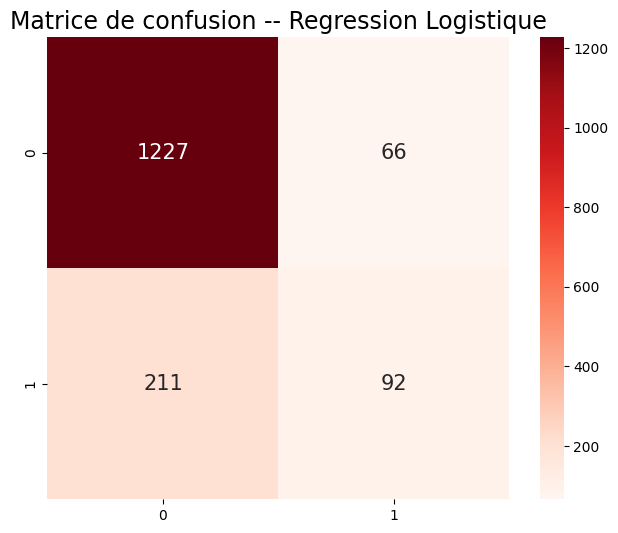

======Pour Regression Logistique======
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1293
           1       0.58      0.30      0.40       303

    accuracy                           0.83      1596
   macro avg       0.72      0.63      0.65      1596
weighted avg       0.80      0.83      0.80      1596





In [167]:
############## MODELE et RESULTAT ####################
from sklearn.linear_model import LogisticRegression
def Logistic_regression(X_train,X_test,y_train,y_test):
  model = LogisticRegression()
  classification('Regression Logistique', model,X_train,X_test,y_train,y_test)
Logistic_regression(Xc_train,Xc_test,yc_train,yc_test)

### B. Arbre de décision

In [168]:
############## MEILLEURS HYPERPARAMETRES ##############
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

def arbre(X_train,X_test,y_train,y_test):
  param_grid = {'max_depth': [None, 5, 10, 15],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4],'max_features': ['auto', 'sqrt', 'log2'],'criterion': ['gini', 'entropy']}

  tree_model = DecisionTreeClassifier(random_state=0);
  grid_search = GridSearchCV(tree_model, param_grid,scoring="recall",n_jobs=-1,cv=5, verbose=1)
  grid_search.fit(X_train, y_train)
  print("Meilleurs hyperparamètres :", grid_search.best_params_)
  model_arbre_decision = grid_search.best_estimator_
  classification('Arbre de décision',model_arbre_decision,X_train, X_test,y_train,y_test)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


360 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
133 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ut

Meilleurs hyperparamètres : {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}


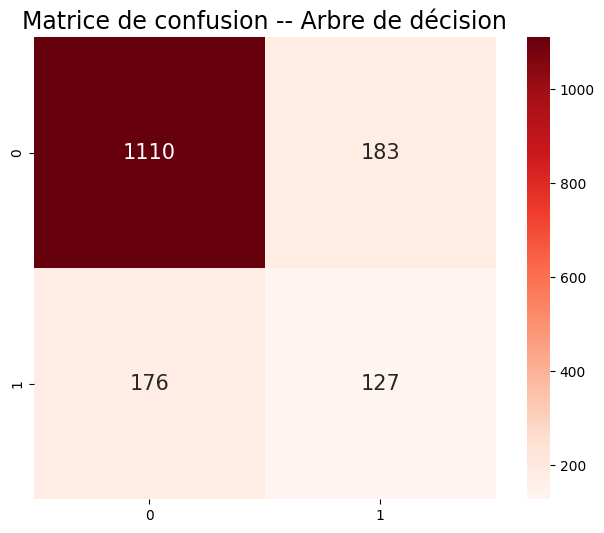

======Pour Arbre de décision======
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1293
           1       0.41      0.42      0.41       303

    accuracy                           0.78      1596
   macro avg       0.64      0.64      0.64      1596
weighted avg       0.78      0.78      0.78      1596





In [169]:
############## MODELE et RESULTAT ####################
arbre(Xc_train, Xc_test,yc_train,yc_test)

### C. Forêt Aléatoire

In [170]:
from sklearn.ensemble import RandomForestClassifier
#Meilleurs hyperparamètres : {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
def foret(X_train,X_test,y_train,y_test):
  rf = RandomForestClassifier()
  param_grid = {'n_estimators': [50, 100, 200],'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}
  random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=5, scoring="precision")
  #grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='recall')
  random_search.fit(X_train, y_train)
  print("Meilleurs hyperparamètres :", random_search.best_params_)

  model_foret_aleatoire = random_search.best_estimator_
  classification('Forêt Aléatoire',model_foret_aleatoire,X_train,X_test,y_train,y_test)

Meilleurs hyperparamètres : {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10}


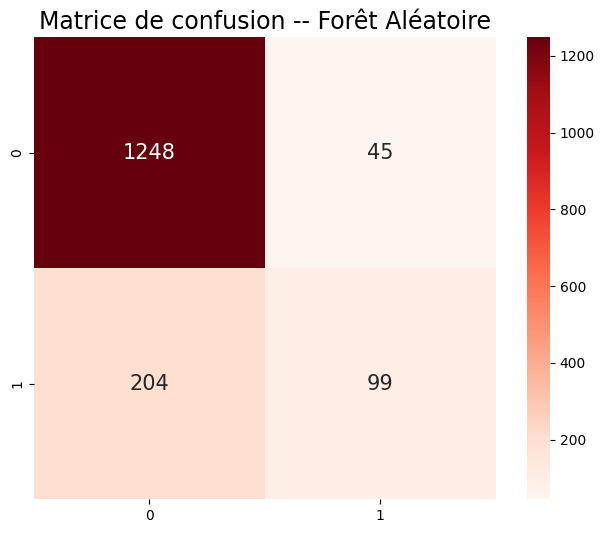

======Pour Forêt Aléatoire======
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1293
           1       0.69      0.33      0.44       303

    accuracy                           0.84      1596
   macro avg       0.77      0.65      0.68      1596
weighted avg       0.83      0.84      0.82      1596





In [171]:
foret(Xc_train,Xc_test,yc_train,yc_test)

### D. k-plus proches voisins (kNN)

In [172]:
################# MEILLEURS HYPERPARAMETRES #########################
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier

def knn(X_train,X_test, y_train,y_test):
  k = range(1,50,2)
  best_recall = 0
  for i in k:
    knn = KNeighborsClassifier(n_neighbors=i)

    knn.fit(X_train, y_train)

    y_pred_test = knn.predict(X_test)
    recall = recall_score(y_test, y_pred_test)

    if best_recall < recall:
        best_recall = recall
        best_k_recall = i
  print('Best Recall:', best_recall, 'Best K-Recall:', best_k_recall)

  knn_model=KNeighborsClassifier(n_neighbors = best_k_recall)
  classification('K Nearest Neighbors',knn_model, X_train,X_test, y_train,y_test)

On constate que le meilleur score de la F-mesure est associé au modèle k-NN avec k=3. Nous appliquons donc le modèle k-NN à nos données, et évaluons sa performance pour k=3.

Best Recall: 0.5379537953795379 Best K-Recall: 1


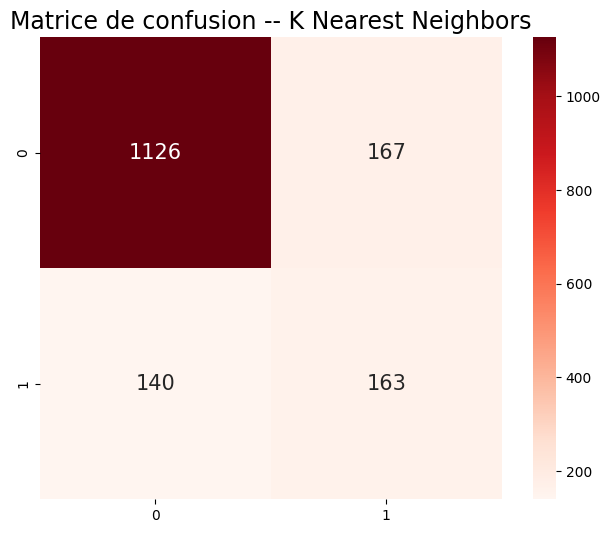

======Pour K Nearest Neighbors======
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1293
           1       0.49      0.54      0.52       303

    accuracy                           0.81      1596
   macro avg       0.69      0.70      0.70      1596
weighted avg       0.81      0.81      0.81      1596





In [173]:
knn(Xc_train,Xc_test, yc_train,yc_test)

On constate que : ...

### E. Support Vector Machine (SVM)


In [174]:
from sklearn.svm import SVC

def support_vector(X_train,X_test,y_train,y_test):
  param_grid = {'C':[0.1,1,10], 'kernel': ['linear', 'rbf', 'poly']}

  svm = SVC()
  grid_search = GridSearchCV(svm, param_grid, cv=5,scoring='recall')
  grid_search.fit(X_train, y_train)
  print("Meilleurs hyperparamètres:", grid_search.best_params_)
  svm_model=grid_search.best_estimator_
  classification('Support Vector Machine',svm_model,X_train,X_test,y_train,y_test)

Meilleurs hyperparamètres: {'C': 10, 'kernel': 'rbf'}


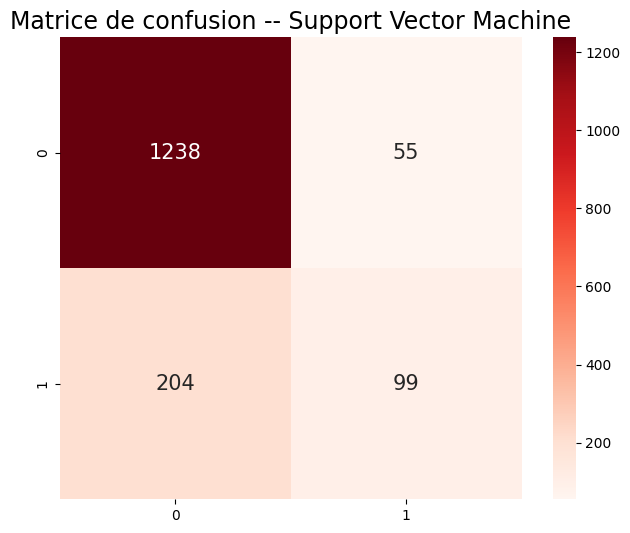

======Pour Support Vector Machine======
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1293
           1       0.64      0.33      0.43       303

    accuracy                           0.84      1596
   macro avg       0.75      0.64      0.67      1596
weighted avg       0.82      0.84      0.82      1596





In [175]:
###### SVM avec MEILLEURS HYPERPARAMÈTRES #######
support_vector(Xc_train,Xc_test,yc_train,yc_test)

### F. Boosting

#### 1. AdaBoost

In [176]:
from sklearn.ensemble import AdaBoostClassifier

def adaboost(X_train,X_test,y_train,y_test):
  ada_boost = AdaBoostClassifier()
  param_grid = {'n_estimators': [50, 100, 150],'learning_rate': [0.01, 0.1, 0.2]}
  grid_search = GridSearchCV(ada_boost, param_grid, cv=5,scoring='recall')
  grid_search.fit(X_train, y_train)
  print("Meilleurs paramètres:", grid_search.best_params_)
  adaboost_model = grid_search.best_estimator_
  classification('AdaBoost',adaboost_model,X_train,X_test,y_train,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: Fu

Meilleurs paramètres: {'learning_rate': 0.2, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



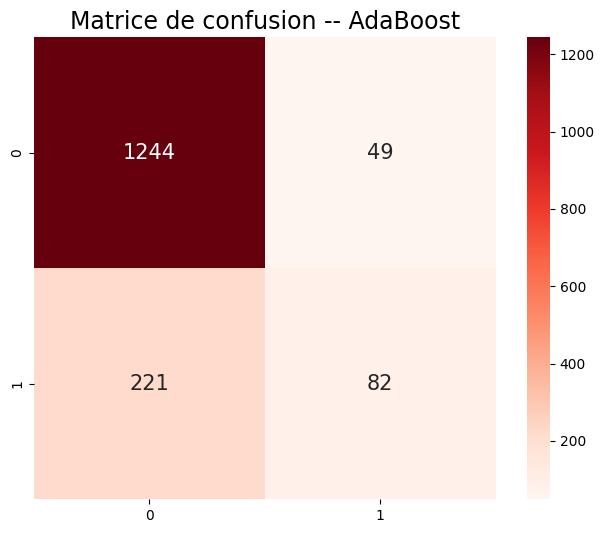

======Pour AdaBoost======
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1293
           1       0.63      0.27      0.38       303

    accuracy                           0.83      1596
   macro avg       0.74      0.62      0.64      1596
weighted avg       0.81      0.83      0.80      1596





In [177]:
###### ADABOOST avec MEILLEURS HYPERPARAMÈTRES #######
adaboost(Xc_train,Xc_test,yc_train,yc_test)

#### 2. Gradient Boosting

In [178]:
from sklearn.ensemble import GradientBoostingClassifier

def gradientboost(X_train,X_test,y_train,y_test):
  gradient_boosting = GradientBoostingClassifier()

  param_grid = {'n_estimators': [50, 100, 150],'learning_rate': [0.01, 0.1, 0.2],'loss': ['ls','deviance', 'exponential']}
  grid_search = GridSearchCV(gradient_boosting, param_grid, cv=5,scoring='recall')
  grid_search.fit(X_train, y_train)
  print("Meilleurs paramètres:", grid_search.best_params_)

  gradboost_model = grid_search.best_estimator_
  classification('Gradient Boosting',gradboost_model,X_train,X_test,y_train,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


90 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

Meilleurs paramètres: {'learning_rate': 0.2, 'loss': 'exponential', 'n_estimators': 150}


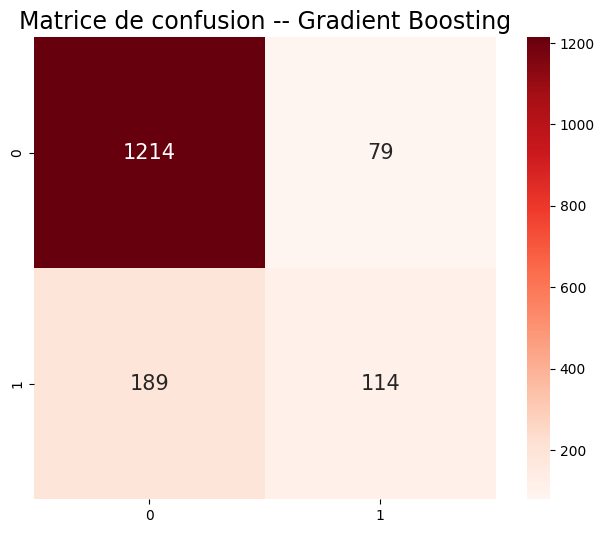

======Pour Gradient Boosting======
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1293
           1       0.59      0.38      0.46       303

    accuracy                           0.83      1596
   macro avg       0.73      0.66      0.68      1596
weighted avg       0.81      0.83      0.82      1596





In [179]:
###### Gradient Boosting avec MEILLEURS HYPERPARAMÈTRES #######
gradientboost(Xc_train,Xc_test,yc_train,yc_test)

#### 3. XGBoost

In [180]:
from xgboost import XGBClassifier

def xg_boost(X_train,X_test,y_train,y_test):
  param_grid = {'learning_rate': [0.01,0.1, 0.2,0.4],'n_estimators': [150,200],'max_depth': [6,8,10],'subsample': [0.4,0.6,0.8],'colsample_bytree': [0.8, 0.9, 1.0]}

  xgb = XGBClassifier(objective='binary:logistic', random_state=42)
  grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='precision')
  grid_search.fit(X_train, y_train)

  print("Meilleurs hyperparamètres pour XGBoost :", grid_search.best_params_)
  xgb_model=grid_search.best_estimator_
  classification('XGBoost',xgb_model,X_train,X_test,y_train,y_test)

Les résultats de classification du modèle optimal XGBoost sont :

Meilleurs hyperparamètres pour XGBoost : {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 150, 'subsample': 0.4}


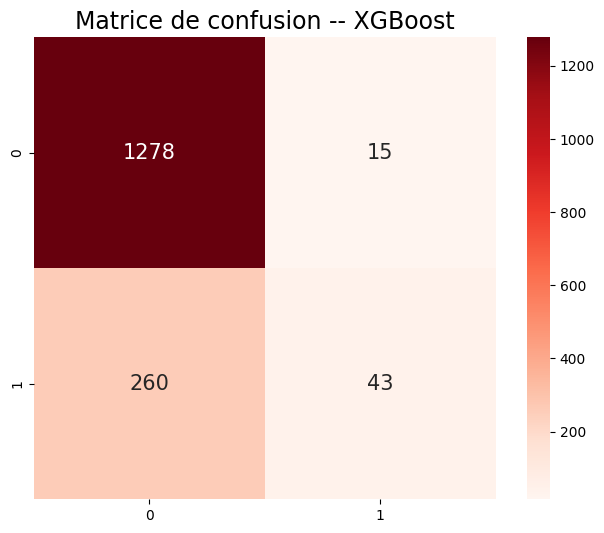

======Pour XGBoost======
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1293
           1       0.74      0.14      0.24       303

    accuracy                           0.83      1596
   macro avg       0.79      0.57      0.57      1596
weighted avg       0.81      0.83      0.78      1596





In [181]:
###### XGBOOST avec MEILLEURS HYPERPARAMÈTRES #######
xg_boost(Xc_train,Xc_test,yc_train,yc_test)

### Ensemble résultats

In [182]:
df_class= pd.DataFrame({'Modèle de classification': liste_algo, 'F1 mesure': score_f1, 'Précision':score_prec, 'Recall':score_recall, 'Accuracy':score_acc}).sort_values(by="F1 mesure",ascending=False)
display(df_class)

,Modèle de classification,F1 mesure,Précision,Recall,Accuracy
3,K Nearest Neighbors,0.515008,0.493939,0.537954,0.807644
6,Gradient Boosting,0.459677,0.590674,0.376238,0.832080
2,Forêt Aléatoire,0.442953,0.687500,0.326733,0.843985
4,Support Vector Machine,0.433260,0.642857,0.326733,0.837719
1,Arbre de décision,0.414356,0.409677,0.419142,0.775063
0,Regression Logistique,0.399132,0.582278,0.303630,0.826441
5,AdaBoost,0.377880,0.625954,0.270627,0.830827
7,XGBoost,0.238227,0.741379,0.141914,0.827694
